In [1]:
# Importing general libraries:-

import numpy as np; 
from scipy.stats import mode;
import pandas as pd;
from pandasql import sqldf;
import regex as re;

import matplotlib.pyplot as plt; 
%matplotlib inline
import seaborn as sns;
sns.set_style('darkgrid');

from warnings import filterwarnings;
from termcolor import colored;

from tqdm.notebook import tqdm;

np.random.seed(10);

In [2]:
# Importing model specific libraries:-
from sklearn_pandas import DataFrameMapper, gen_features;

from sklearn.compose import make_column_selector;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.pipeline import make_pipeline, Pipeline ;
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder;
from sklearn.impute import SimpleImputer;

from sklearn.model_selection import KFold, GridSearchCV;
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier;
from xgboost import XGBClassifier;
from lightgbm import LGBMClassifier;
from sklearn.svm import SVC;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.linear_model import LogisticRegression;

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix;

# Titanic- Machine Learning from disaster

In [3]:
# Loading relevant data-sets:-
xytrain = pd.read_csv('../input/titanic/train.csv', encoding = 'utf8');
xtest = pd.read_csv('../input/titanic/test.csv', encoding = 'utf8');

# Splitting the training data into features and target:-
xtrain, ytrain = xytrain.drop('Survived', axis= 1), xytrain[['Survived']];

print(colored(F"Train-Test dataframe lengths = {len(xytrain), len(xtest)}", color= 'blue', attrs= ['bold']));
print(colored(F"\nTrain-set information\n", color = 'blue', attrs= ['bold', 'dark']));
display(xytrain.info());
print(colored(F"\nTrain-set description\n", color = 'blue', attrs= ['bold', 'dark']));
display(xytrain.describe().style.format('{:.2f}'));

Train-Test dataframe lengths = (891, 418)

Train-set information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Train-set description



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


# 1. Data processing and visualization

We explore the data set, look into the features, study their distributions, assess nulls and understand the data effectively in this section.
These ideas will be used in the next section in the data pipeline.

### a. Target column details:-

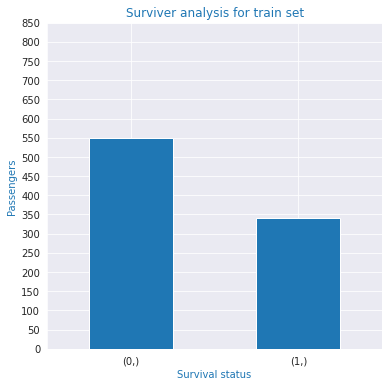

In [4]:
plt.subplots(1,1,figsize= (6,6));
ax = ytrain.value_counts().plot.bar(color= 'tab:blue');
ax.set_title("Surviver analysis for train set", color = 'tab:blue', fontsize= 12);
ax.set_xlabel('Survival status', color= 'tab:blue');
ax.set_yticks(range(0, len(xtrain), 50));
ax.set_ylabel('Passengers', color= 'tab:blue');
plt.xticks(rotation = 0);
plt.show();

### b. Passenger class and gender:-


Survival rate by gender and pclass



,,Survivors,Passengers,Survival_Rate
Sex,Pclass,,,
female,1,91,94,96.81%
male,1,45,122,36.89%
female,2,70,76,92.11%
male,2,17,108,15.74%
female,3,72,144,50.00%
male,3,47,347,13.54%


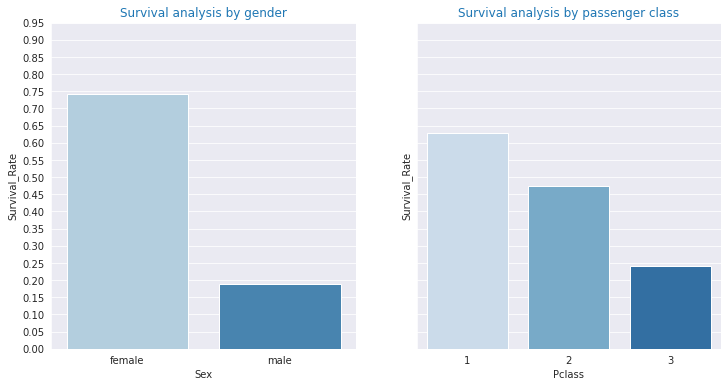

In [5]:
_ = xytrain.groupby(['Sex', 'Pclass']).agg(Survivors = pd.NamedAgg('Survived', np.sum),Passengers = pd.NamedAgg('Survived', np.size)).sort_index(level=[1,0])
_['Survival_Rate'] = _['Survivors'] / _['Passengers'];
print(colored(f'\nSurvival rate by gender and pclass\n', color = 'blue', attrs= ['bold', 'dark']));
display(_.style.format({'Survival_Rate':'{:.2%}'}))

_0 = _.groupby(level= 0).agg({'Survivors':np.sum, 'Passengers':np.sum});
_0['Survival_Rate'] = _0['Survivors'] / _0['Passengers'];

_1 = _.groupby(level= 1).agg({'Survivors':np.sum, 'Passengers':np.sum});
_1['Survival_Rate'] = _1['Survivors'] / _1['Passengers'];

print('\n');
fig, ax = plt.subplots(nrows= 1,ncols=2,figsize = (12,6), sharey= True);
sns.barplot(x = _0.index, y = _0.Survival_Rate, palette = 'Blues', ax = ax[0]);
sns.barplot(x = _1.index, y = _1.Survival_Rate, palette = 'Blues', ax= ax[1]);
ax[0].set_title("Survival analysis by gender", color = 'tab:blue', fontsize = 12);
ax[1].set_title("Survival analysis by passenger class", color = 'tab:blue', fontsize = 12);
plt.yticks(np.arange(0,1,0.05),fontsize= 8, color = 'blue');
plt.show()

del _, _0, _1;

### c. Age:-

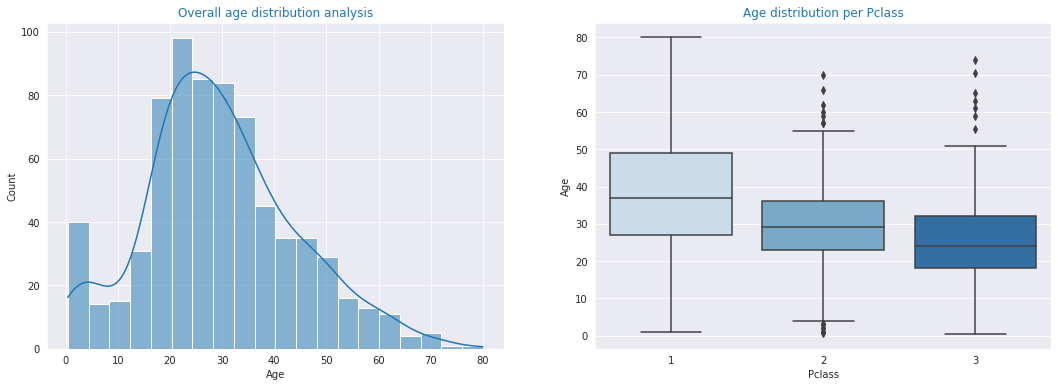

In [6]:
fig, ax = plt.subplots(1,2,figsize = (18,6));
sns.histplot(x = xytrain['Age'], kde= True, palette = 'Blues', ax = ax[0]);
ax[0].set_title(f"Overall age distribution analysis", color = 'tab:blue', fontsize= 12 )

sns.boxplot(x = xytrain.Pclass, y = xytrain.Age, palette = 'Blues', ax = ax[1]);
ax[1].set_title(f"Age distribution per Pclass", color = 'tab:blue', fontsize= 12);

plt.show();

### d. Ticket fare:-

In [7]:
print(colored(f"\nTicket fare by Pclass and survivorship\n", color = 'blue', attrs= ['bold', 'dark']));
display(xytrain.groupby(['Pclass', 'Survived']).agg({'Fare': [np.amin, np.median, np.mean, np.amax]}).style.format('{:.2f}'))


Ticket fare by Pclass and survivorship



### e. Null valued columns:-

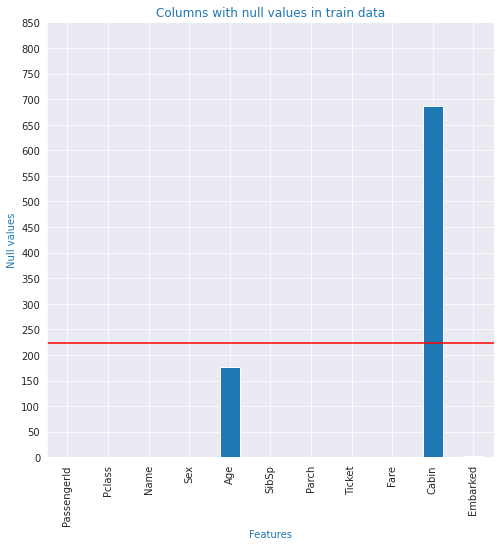

Nulls in train data



PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

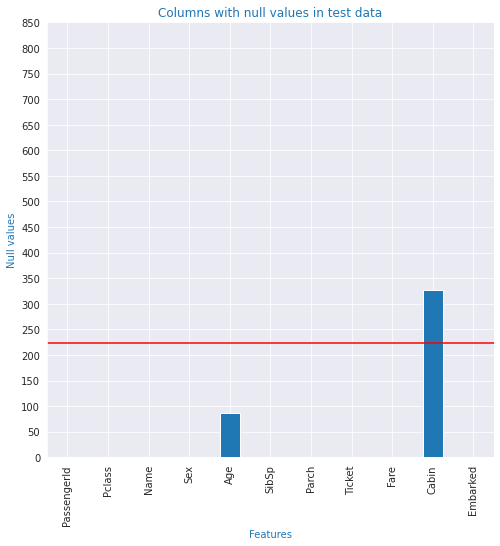

Nulls in test data



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
# Plotting null columns across the data-sets:-
def Plot_NullCol(df, df_type):
    """
    This function plots the relevant data-set and scans for nulls across columns
    Inputs- 
    df (dataframe):- The relevant data-frame for analysis
    df_type (string):- Type of data (training/ test)
    """;
    
    global xtrain;
    _ = df.isna().sum(axis= 0);
    print('\n');
    
    plt.subplots(1,1, figsize= (8,8))
    ax= _.plot.bar(color= 'tab:blue');
    ax.set_title(f"Columns with null values in {df_type} data", color = 'tab:blue', fontsize= 12);
    ax.set_yticks(range(0, len(xtrain),50));
    ax.axhline(y= len(xtrain)/4, linewidth = 1.5, color= 'red');
    ax.set_ylabel('Null values', color = 'tab:blue');
    ax.set_xlabel('Features', color = 'tab:blue');
    plt.show();
    
    print(colored(f"Nulls in {df_type} data\n", color = 'blue'));
    display(_);
    del _;
    

# Plotting the train-test for nulls:-
Plot_NullCol(xtrain, df_type= 'train');
Plot_NullCol(xtest, df_type= 'test');

### f. Cabin null inference in training set:-

In [9]:
print(colored(f"\nCabin column null inferences in training data-set\n", color = 'blue', attrs= ['bold', 'dark']));
display(xytrain.assign(Cabin_cat = xtrain.Cabin.str[0:1]).groupby(['Cabin_cat', 'Pclass'], dropna= False).\
        agg({'Fare':[np.median, np.mean, np.amin, np.amax], 
             'PassengerId':[np.size], 
             'Survived': [np.sum]})\
        .style.format('{:,.0f}'));


Cabin column null inferences in training data-set



## Creating pipeline adjutant functions and classes:-


In [10]:
def TreatCabinNulls(df1:pd.DataFrame):
    """
    This is an added function to treat the null valued cabin column in both the train and test data. 
    This is designed to impute the nulls instead of dropping the column entirely.
    The treatment of nulls follows the below process-
    1. Create a composite variable with the cabin category (1st letter in the cabin column) and the Pclass. 
       This is an interaction variable
    2. Consider passengers with the same Pclass as the subject
    3. Map the composite Cabin category with the null instances in the cabin based on the lowest fare difference. 
       Windowing SQL functions are used for the same
    4. For cases where fare is not available, use the mode of the cabin category per Pclass. 
    
    Input- df1 (dataframe):- Input dataframe without treatment
    Returns- df (dataframe):- Dataframe with the cabin nulls treated 
    """;
    
    global xtrain, xtest;
    
    cabin_trmt_prf = \
    sqldf(f""" 
    select PassengerId, Pclass, Fare, Embarked, Cabin from xtrain 
    union all 
    select PassengerId, Pclass, Fare, Embarked, Cabin from xtest
    """);

    #  Creating the proxy variable with the fare and Pclass:-   
    cabin_trmt_mst = \
    sqldf(f"""
    select A1.PID1 as PassengerId, A1.Pclass, A1.Cabin_Ctg_Lbl
    from 
    (
    select a.PassengerId as PID1,a.Pclass, b.PassengerId as PID2, b.Cabin_Ctg_Lbl, a.Fare as Fare1, b.Fare as Fare2, abs(a.Fare - b.Fare) as Fare_Diff,
    row_number() over(partition by a.PassengerId order by abs(a.Fare - b.Fare) asc) as Fare_Diff_Rank
    from 
    (select PassengerId, Pclass, Fare, Embarked from cabin_trmt_prf WHERE Cabin is null) A 
    inner join 
    (
    select PassengerId, Pclass, Fare, (cast(Pclass as varchar(1)) || substr(Cabin,1,1)) AS Cabin_Ctg_Lbl, Embarked 
    from cabin_trmt_prf 
    where Cabin is not null
    ) B on (A.Pclass = B.Pclass and abs(a.Fare - b.Fare) <= 50)
    ) A1
    where A1.Fare_Diff_Rank == 1
    """);
    
    #  Finally appending the nulls still present with the mode of the Pclass and Category label:-
    cabin_md_sum = \
    sqldf("""
    select a.* from 
    (
    select Pclass, Cabin_Ctg_Lbl, count(PassengerId) as cnt, row_number() over (order by count(PassengerId) desc) as rank_id
    from cabin_trmt_mst 
    group by Pclass, Cabin_Ctg_Lbl
    ) a
    where a.rank_id = 1
    """);
 
    # Mapping the interaction variable to the relevant table:-    
    df = df1.copy();   
    df = sqldf("""
    select a.*, coalesce(coalesce(b.Cabin_Ctg_Lbl, cast(a.Pclass as varchar(1)) || substr(a.Cabin,1,1)), c.Cabin_Ctg_Lbl) as Cabin_Class_Lbl 
    from df a 
    left join cabin_trmt_mst b on a.PassengerId = B.PassengerId
    left join cabin_md_sum c on a.Pclass = c.Pclass
    """);  
    
    del cabin_trmt_mst, cabin_trmt_prf, cabin_md_sum; 
    return df;  

In [11]:
def Xform_Data(df1:pd.DataFrame): 
    """
    This function does the below tasks:-
    1. Creates a title attribute from the name column
    2. Assigns 'others' to uncommon titles
    3. Creates a flag for 'child' from the title. This is used to fill in the age nulls.
    4. Creates a 'family members count' column from the Sibsp and Parch attributes
    5. Drops superfluous columns
    
    Input- df (dataframe):- Analysis dataframe
    Returns- df (dataframe):- Modified dataframe   
    """;
    
    filterwarnings(action= "ignore");
    df = df1.copy();
    
    df['Title'] = df['Name'].apply(lambda x: re.findall(r"\S+\. ",x)[0].strip()[0:-1]);
    df['Title'].loc[~df.Title.isin(['Mr', 'Mrs', 'Miss', 'Master'])] = 'Others';
    df['Is_child'] = np.select([df['Title'].str.lower() == 'master'], ['Y'], 'N');    
    df['Nb_Fmly_Mem'] = df['SibSp'].fillna(0) + df['Parch'].fillna(0);  
    df = df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis= 1);  
    
    return df;

In [12]:
class AgeImputer(BaseEstimator, TransformerMixin):
    """This class is designed to fill-up the age null values with the child/ adult gender based medians""";
    def __init__(self): pass
    def fit(self, X, y=None, **fit_params):
        "This function learns the training medians across the child and adult groups for filling nulls";
        self.median_ = X.groupby(['Is_child','Sex'])[['Age']].median().reset_index();
        return self;
    def transform(self, X, y=None, **transform_params):
        "This function imputes the null values in the relevant data-set according to the medians";
        X1 = X.merge(self.median_, how= 'left', on= ['Is_child', 'Sex'], suffixes= ('', '_Median'));
        X1['Age'] = X1['Age'].fillna(X1.Age_Median);
        X1 = X1.drop(['Age_Median'], axis= 1);
        return X1;

In [13]:
class FareImputer(BaseEstimator, TransformerMixin):
    """This class is designed to fill-up the ticket fare null values with the Pclass medians""";
    def __init__(self): pass
    def fit(self, X, y=None, **fit_params):
        "This function learns the training medians across the Pclass groups for filling nulls";
        self.median_ = X.groupby(['Pclass'])[['Fare']].median().reset_index();
        return self;
    def transform(self, X, y=None, **transform_params):
        "This function imputes the null values in the relevant data-set according to the medians";
        X1 = X.merge(self.median_, how= 'left', on= ['Pclass'], suffixes= ('', '_Median'));
        X1['Fare'] = X1['Fare'].fillna(X1.Fare_Median);
        X1 = X1.drop(['Fare_Median'], axis= 1);
        return X1;

In [14]:
class AgeFareBinner(BaseEstimator, TransformerMixin):
    """
    This class develops bins for the age and ticket fare, to foster stability and offer better and stable predictability.
    Training set parameters are developed with the fit function. 
    """;
    
    def __init__(self, nb_age_bins: int = 5, nb_fare_bins:int = 5): 
        self.nb_age_bins = nb_age_bins
        self.nb_fare_bins = nb_fare_bins
    
    def fit(self, X, y= None, **fit_params):
        """This function calculates the bins for the age and fare columns respectively""";     
        self.age_bins_ = pd.qcut(X['Age'], q = self.nb_age_bins, retbins= True, labels = range(1,self.nb_age_bins + 1,1))[1];
        self.fare_bins_ = pd.qcut(X['Fare'], q = self.nb_fare_bins, retbins= True, labels = range(1,self.nb_fare_bins + 1,1))[1];   
        return self;
        
    def transform(self, X, y=None, **transform_param):
        """This function applies the binned results to the relevant dataframe and returns the labelled column""";        
        X1 = X.copy();
        
        self.age_bins_[0] = 0.0; self.fare_bins_[0] = 0.0;
        self.age_bins_[-1] = np.inf; self.fare_bins_[-1] = np.inf;
        
        X1['Age_Bin'] = pd.cut(X1['Age'], self.age_bins_, retbins= False, labels = range(1,self.nb_age_bins + 1,1), include_lowest= True);
        X1['Fare_Bin'] = pd.cut(X1['Fare'], self.fare_bins_, retbins= False, labels = range(1,self.nb_age_bins + 1,1), include_lowest= True); 
               
        global df_col; df_col = list(X1.columns);
        return X1;      

# 2. Model pipeline development

Key pipeline steps:-
* Treat nulls in cabin- This step treats nulls in cabin using Pclass and Fare, also fills up remaining nulls after treatment with the Pclass mode
* Transform data- This step adds the new features and drops some redundant features.
* Impute Embarked- This step imputes the null values in the column with the mode
* Label encoder- This is used for the selected object columns only
* Impute age- This is used to impute age based on the grouped median of child/ adult and gender
* Impute fare- This fills fare column nulls based on the median of Pclass fare
* Bin Age Fare- This bins the age and fare columns (this is not used in the latest version)
* Robust Scaler- This is used for numerical columns only as selected in the column list

In [15]:
nb_age_bins = 5;
nb_fare_bins = 5;
enc_col_lst = ['Sex', 'Embarked', 'Title', 'Is_child'];
std_col_lst = ['Age', 'Fare', 'SibSp', 'Parch', 'Nb_Fmly_Mem' ]

Data_Processor = \
Pipeline(verbose=True, 
         steps= \
         [('Imp_Cabin', FunctionTransformer(func= TreatCabinNulls)),
          ('Xform_Data', FunctionTransformer(func= Xform_Data)),
          ('Imp_Embk', DataFrameMapper(default= None, input_df= True, df_out= True, 
                                             features= [(['Embarked'], SimpleImputer(strategy= 'most_frequent'))])
          ),
          ('Lbl_Enc', DataFrameMapper(default= None, input_df= True, df_out= True, 
                                            features = gen_features([col.split(' ') for col in enc_col_lst], [LabelEncoder]))
          ),
          ('Imp_Age', AgeImputer()),
          ('Imp_Fare',FareImputer()),
          ('Ord_Enc', DataFrameMapper(default= None, input_df= True, df_out= True, 
                                      features= [(['Cabin_Class_Lbl'], OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value= 49))])
          ),
#           ('BinAgeFare', AgeFareBinner(nb_age_bins = nb_age_bins, nb_fare_bins = nb_fare_bins)),
          ('Std', DataFrameMapper(default= None, input_df= True, df_out= True, 
                                  features = gen_features([col.split(' ') for col in std_col_lst], [RobustScaler])))
         ]
        );

In [16]:
print(colored(f"\nPipeline details\n", color = 'blue'));
Data_Processor.fit(xtrain, ytrain);

# Train-set transformation:-
print(colored(f"\nPipeline implementation for the training set\n", color= 'blue', attrs= ['bold', 'dark']));
Xtrain = Data_Processor.transform(xtrain);

print(colored(f"\nNull check after pipeline\n", color = 'blue'));
display(Xtrain.isna().sum(axis=0));
print(colored(f'\nData description after pipeline\n', color = 'blue'));
display(Xtrain.describe().style.format('{:.2f}'));

# Test-set transformation:-
print(colored(f"\nPipeline implementation for the test set\n", color= 'blue', attrs= ['bold', 'dark']));
Xtest = Data_Processor.transform(xtest);

print(colored(f"\nNull check after pipeline\n", color = 'blue'));
display(Xtest.isna().sum(axis=0));


Pipeline details

[Pipeline] ......... (step 1 of 8) Processing Imp_Cabin, total=   0.8s
[Pipeline] ........ (step 2 of 8) Processing Xform_Data, total=   0.0s
[Pipeline] .......... (step 3 of 8) Processing Imp_Embk, total=   0.0s
[Pipeline] ........... (step 4 of 8) Processing Lbl_Enc, total=   0.0s
[Pipeline] ........... (step 5 of 8) Processing Imp_Age, total=   0.0s
[Pipeline] .......... (step 6 of 8) Processing Imp_Fare, total=   0.0s
[Pipeline] ........... (step 7 of 8) Processing Ord_Enc, total=   0.0s
[Pipeline] ............... (step 8 of 8) Processing Std, total=   0.0s

Pipeline implementation for the training set


Null check after pipeline



Age                0
Fare               0
SibSp              0
Parch              0
Nb_Fmly_Mem        0
Cabin_Class_Lbl    0
Sex                0
Embarked           0
Title              0
Is_child           0
Pclass             0
dtype: int64


Data description after pipeline



,Age,Fare,SibSp,Parch,Nb_Fmly_Mem,Cabin_Class_Lbl,Sex,Embarked,Title,Is_child,Pclass
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,-0.04,0.77,0.52,0.38,0.90,7.44,0.65,1.54,1.91,0.04,2.31
std,1.01,2.15,1.10,0.81,1.61,3.38,0.48,0.79,0.80,0.21,0.84
min,-2.28,-0.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,-0.62,-0.28,0.00,0.00,0.00,6.00,0.00,1.00,2.00,0.00,2.00
50%,0.00,0.00,0.00,0.00,0.00,9.00,1.00,2.00,2.00,0.00,3.00
75%,0.38,0.72,1.00,0.00,1.00,10.00,1.00,2.00,2.00,0.00,3.00
max,3.85,21.56,8.00,6.00,10.00,11.00,1.00,3.00,4.00,1.00,3.00



Pipeline implementation for the test set


Null check after pipeline



Age                0
Fare               0
SibSp              0
Parch              0
Nb_Fmly_Mem        0
Cabin_Class_Lbl    0
Sex                0
Embarked           0
Title              0
Is_child           0
Pclass             0
dtype: int64

### Model parameter setting and implementation:-

Key models and description:-
1. Logistic Regression
2. SVC classifier
3. Single tree
4. Ensemble random forest
5. Gradient boosting machine
6. Light GBM
7. XgBoost Classifier

Model outputs are stored in 2 tables- 
1. Model parameters profile (mdl_param_prf)- This stores the model name and relevant score metrics
2. Model prediction profile (mdl_pred_prf) - This stores the test set predictions from each model (best estimator)

In [17]:
# Creating a master dictionary for the model parameters and class instances:-
mdl_mst_dict = \
{
'Logistic': [LogisticRegression(random_state = 10), {}],
'SVC': [SVC(random_state = 10), {'C': range(3,10,1)}],
'DTree' : [DecisionTreeClassifier(random_state= 10), {'max_depth': range(4,8,1), 'min_samples_leaf' : range(3,12,1)}],
'RandomForest': [RandomForestClassifier(random_state =10), 
                 {'n_estimators': range(50,300,25), 'max_depth': range(4,7,1)}],
'GBM': [GradientBoostingClassifier(random_state= 10), {'max_depth' : range(2,6,1)}],
'LGBM': [LGBMClassifier(random_state = 10),{}],
'XgBoost': [XGBClassifier(eval_metric= 'logloss'), {}]
};

cv = None;

# Creating model output storage objects:-
mdl_param_prf = pd.DataFrame(data= None, index= list(mdl_mst_dict.keys()), dtype= np.float32,
                             columns= ['Precision_Score', 'Recall_Score', 'F1_Score', 'ROC_AUC_Score', 'Accuracy_Score']);
mdl_pred_prf = pd.DataFrame(data= None, index= None, columns= None, dtype= np.int32);

Implementation routine- 
1. Load the relevant model
2. Fit the model with the grid search parameters
3. Create relevant scores for the training set
4. Extract test set predictions
5. Integrate the data accordingly into the output tables

In [18]:
# Implementing all models:-
for mdl_lbl, mdl_param in tqdm(mdl_mst_dict.items()):
    print(colored(f"\nCurrent model is {mdl_lbl}", color = 'red', attrs= ['bold', 'dark']));
    grid = GridSearchCV(estimator = mdl_param[0], param_grid = mdl_param[1], scoring='accuracy', refit=True,cv=cv);
    grid.fit(Xtrain, ytrain);
    print(colored(f"""Best estimator is \n{grid.best_estimator_}\n""", color = 'blue'));
    
    ytrain_pred = grid.predict(Xtrain);  
    print(colored(f"Confusion matrix\n{confusion_matrix(ytrain['Survived'].values, ytrain_pred)}", color = 'blue'));
    
    mdl_param_prf.loc[mdl_lbl] = (precision_score(ytrain['Survived'].values, ytrain_pred),
                                  recall_score(ytrain['Survived'].values, ytrain_pred),
                                  f1_score(ytrain['Survived'].values, ytrain_pred),
                                  roc_auc_score(ytrain['Survived'].values, ytrain_pred),
                                  accuracy_score(ytrain['Survived'].values, ytrain_pred)
                                 );
    
    mdl_pred_prf = pd.concat((mdl_pred_prf,pd.DataFrame(grid.predict(Xtest), index = Xtest.index, columns = [mdl_lbl], dtype= np.int32)),
                             axis= 1, join='outer');

print(colored(f"\n\nTraining set scores across models:-\n", color = 'blue', attrs= ['bold', 'dark']))
display(mdl_param_prf.style.format('{:.2%}'));

  0%|          | 0/7 [00:00<?, ?it/s]


Current model is Logistic
Best estimator is 
LogisticRegression(random_state=10)

Confusion matrix
[[489  60]
 [ 84 258]]

Current model is SVC
Best estimator is 
SVC(C=8, random_state=10)

Confusion matrix
[[493  56]
 [ 89 253]]

Current model is DTree
Best estimator is 
DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, random_state=10)

Confusion matrix
[[510  39]
 [ 81 261]]

Current model is RandomForest
Best estimator is 
RandomForestClassifier(max_depth=6, n_estimators=200, random_state=10)

Confusion matrix
[[524  25]
 [ 89 253]]

Current model is GBM
Best estimator is 
GradientBoostingClassifier(max_depth=5, random_state=10)

Confusion matrix
[[541   8]
 [ 29 313]]

Current model is LGBM
Best estimator is 
LGBMClassifier(random_state=10)

Confusion matrix
[[538  11]
 [ 31 311]]

Current model is XgBoost
Best estimator is 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
  

,Precision_Score,Recall_Score,F1_Score,ROC_AUC_Score,Accuracy_Score
Logistic,81.13%,75.44%,78.18%,82.25%,83.84%
SVC,81.88%,73.98%,77.73%,81.89%,83.73%
DTree,87.00%,76.32%,81.31%,84.61%,86.53%
RandomForest,91.01%,73.98%,81.61%,84.71%,87.21%
GBM,97.51%,91.52%,94.42%,95.03%,95.85%
LGBM,96.58%,90.94%,93.67%,94.47%,95.29%
XgBoost,97.87%,93.86%,95.82%,96.29%,96.86%


# 3. Submission file preparation

We explore a few options from the developed models and prepare the submissio file in this section. This is the last section in the model framework.

In [19]:
print(colored(f"Sample submission file\n", color= 'blue', attrs= ['dark', 'bold']));
display(pd.read_csv('../input/titanic/gender_submission.csv', encoding= 'utf8').head(5));
display(pd.read_csv('../input/titanic/gender_submission.csv', encoding= 'utf8').tail(5));

Sample submission file



,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [20]:
# Adding new columns for specific mode values:-
mdl_pred_prf['AllModels'] = mode(mdl_pred_prf, axis=1)[0];
mdl_pred_prf['BoostedTree'] = mode(mdl_pred_prf[['GBM', 'LGBM', 'XgBoost']], axis=1)[0];
mdl_pred_prf['Ensemble'] = mode(mdl_pred_prf[['GBM', 'LGBM', 'XgBoost', 'RandomForest']], axis=1)[0];

In [21]:
sel_col_nm = 'AllModels';
pd.DataFrame(mdl_pred_prf[sel_col_nm].values, index = xtest.PassengerId, 
             columns = ['Survived'], dtype= np.int32).reset_index().to_csv("Submission.csv", index= False);